In [1]:
import sys
sys.path.append('python/')
import numpy as np
from matplotlib import pyplot as plt
import crowdmag as cm
import filterdata as filt
from matplotlib import ticker
from datetime import datetime
import time

# Filter tests (CrowdMag data)

Here are some of the options to filter data in Python: https://docs.scipy.org/doc/scipy/reference/signal.html

In [35]:
filenameCM = 'crowdmag_7-7-22_iPhone12,1_2022-07-08 012026.csv'
#filenameCM = 'crowdmag_3-28-22_iPhone12,1_2022-03-28 150111.csv'
#filenameCM = 'crowdmag_3-22-22_iPhone12,1_2022-03-23 015401.csv'
#filenameCM = 'crowdmag_March 14 2022_iPhone12,1_2022-03-14 135556.csv'
#filenameCM = 'crowdmag_March 9 2022_iPhone12,1_2022-03-09 164809.csv'

# Parameters
timestep = 70                      # Sampling rate in seconds
pathCM = 'data/crowdmag/'          # Path of the data files
fieldtype = 'F'                    # Field component
startCM = 3                        # Trim first 3 datapoints
endCM = -1                         # Trim end points, -1 is no trimming

# Read data
date,totalmag,magH,magX,magY,magZ = cm.ReadCSVCrowdMag(pathCM + filenameCM, startCM = startCM, endCM = endCM, rollingave = False)

#time = date[3791:5025]
timearray = np.linspace(0,len(date),len(date))
original_mag = totalmag#[3791:5025]
print(type(date))
print(len(date))

<class 'numpy.ndarray'>
4011


## Raw data

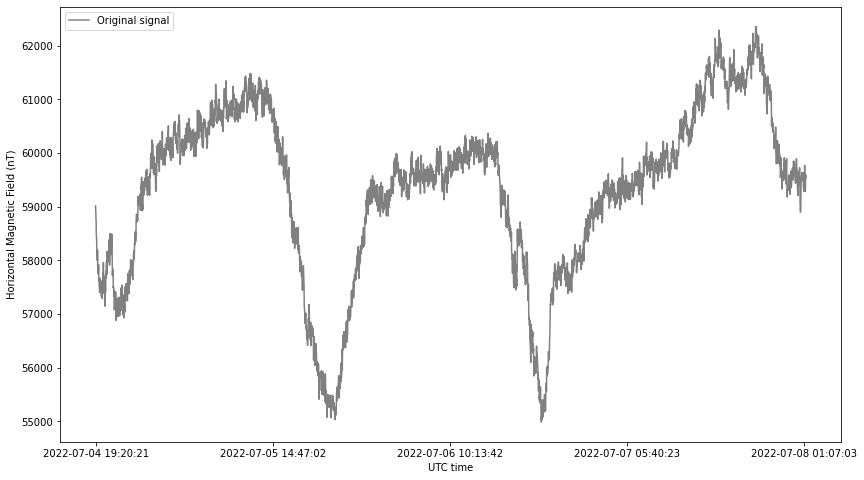

In [36]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
plt.plot(date, original_mag, label='Original signal', color='grey')
plt.xlabel('UTC time')
plt.ylabel('Horizontal Magnetic Field (nT)')
#plt.xlim(4000,5500)
xticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(xticks)
plt.legend()
plt.show()

## Check delta time

In [4]:
# Calculate total time in seconds
timeinseconds = []
for d in date:
    x = time.strptime(d,'%Y-%m-%d %H:%M:%S')
    dt = datetime(x.tm_year,x.tm_mon,x.tm_mday,x.tm_hour,x.tm_min,x.tm_sec)
    dtseconds = (dt-datetime(1970,1,1)).total_seconds()
    timeinseconds.append(dtseconds)
timeinseconds = np.array(timeinseconds)

In [5]:
# Calculate time difference between each measurements
deltatime = []
for t in range(len(timeinseconds)):
    if t < len(timeinseconds)-1:
        dt = timeinseconds[t+1] - timeinseconds[t]
        deltatime.append(dt)
    else:
        pass
deltatime = np.array(deltatime)

# Print "There is a gap!" if the delta time is not equal to 70 seconds
for dt in range(len(deltatime)):
    if deltatime[dt] != 70:
        print("There is a gap!")
print(deltatime)

There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is a gap!
There is

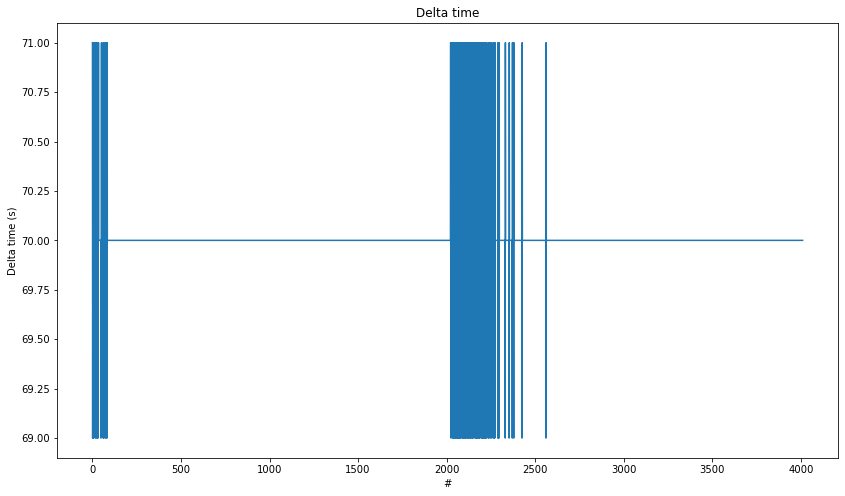

In [6]:
# Plot
plt.figure(figsize=(14, 8))
plt.title('Delta time')
plt.plot(np.linspace(0,len(deltatime),len(deltatime)), deltatime)
plt.xlabel('#')
plt.ylabel('Delta time (s)')
plt.show()

## DC Shift

#### Change point detection:
https://ctruong.perso.math.cnrs.fr/ruptures-docs/build/html/detection/window.html
 
    Window-based: Window-based change point detection is used to perform fast signal segmentation and is implemented in Window. The algorithm uses two windows which slide along the data stream. 

https://centre-borelli.github.io/ruptures-docs/user-guide/detection/binseg/
    
    Binary change point detection: is used to perform fast signal segmentation and is implemented in Binseg. It is a sequential approach: first, one change point is detected in the complete input signal, then series is split around this change point, then the operation is repeated on the two resulting sub-signals.
    
https://centre-borelli.github.io/ruptures-docs/user-guide/detection/dynp/
    
    Dynamic programming: It finds the (exact) minimum of the sum of costs by computing the cost of all subsequences of a given signal. It is called "dynamic programming" because the search over all possible segmentations is ordered using a dynamic programming approach. In order to work, the user must specify in advance the number of changes to detect. 

https://centre-borelli.github.io/ruptures-docs/user-guide/detection/pelt/

    Linearly penalized segmentation: Because the enumeration of all possible partitions impossible, the algorithm relies on a pruning rule. Many indexes are discarded, greatly reducing the computational cost while retaining the ability to find the optimal segmentation. 

https://centre-borelli.github.io/ruptures-docs/user-guide/detection/bottomup/

    Contrary to binary segmentation, which is a greedy procedure, bottom-up segmentation is generous: it starts with many change points and successively deletes the less significant ones. First, the signal is divided in many sub-signals along a regular grid. Then contiguous segments are successively merged according to a measure of how similar they are.

Other sources: <br> 
https://www.kaggle.com/code/yejining99/change-point-detection/notebook<br>
https://ctruong.perso.math.cnrs.fr/ruptures-docs/build/html/detection/window.html

In [7]:
import ruptures as rpt
from scipy import signal

In [8]:
# Parameters
n_bkps = 1                                                 # Number of breaking points
method = 'Window'                                          # Change point detection method
model = "l2"  # "l1", "rbf", "linear", "normal", "ar"      # Segment model

# Change point detection
if method == 'Window':
    algo = rpt.Window(width=40,model=model).fit(original_mag)        # Window sliding method to find breaking points
if method == 'Binseg':
    algo = rpt.Binseg(model=model).fit(original_mag)                 # Binary segmentation method to find breaking points
if method == 'Dynp':
    algo = rpt.Dynp(model=model,min_size=3,jump=5).fit(original_mag) # Dynamic programming method to find breaking points
if method == 'Pelt':
    algo = rpt.Pelt(model=model,min_size=3,jump=5).fit(original_mag) # Linearly penalized segmentation method to find breaking points
if method == 'Bottomup':
    algo = rpt.BottomUp(model=model).fit(original_mag)               # Bottom-up segmentation method to find breaking points

# Predict the location of breaking points in the signal
my_bkps = algo.predict(n_bkps)
print('Breaking points in the signal = {}'.format(my_bkps))

# Define segments using the breaking points
start = 0                                                  # Starting point of the data set
segmented_list = []                                        # Empty list for the segmented lists
for i in range(len(original_mag)):                         # Loop through the magnetic field strength measurements
    for p in my_bkps:                                      # But also loop through the breaking point list
        if i == p:                                         # If the index equals the breaking point
            segment = original_mag[start:p]                # Define a new segment from start point to the breaking point
            segmented_list.append(segment)                 # Append this new segment to the segmented list
            start = p                                      # Redefine the starting point
last_segment = original_mag[start:]                        # Define last segment
segmented_list.append(last_segment)                        # Append last segment to the segmented list
segmented_list = np.array(segmented_list,dtype=object)     # Convert list to numpy array

maglength = len(original_mag)                              # Length of data
print(len(segmented_list))

# DC Shift each segment to zero, detrend
mag = []                                                   # Empty list for the shifted field strength
for s in segmented_list:                                   # Loop through each segment
    mean = np.mean(s)                                      # Mean of segment
    shifted_s = s - mean                                   # DC shift
    mag.append(shifted_s)                                  # Append shifted signal to the shifted field strength list
mag = np.array(mag,dtype=object)                           # Convert list to numpy array
mag = np.concatenate(mag,axis=0)                           # Concatenate the whole sequence of arrays

# Remove outliers
mag = filt.Outliers(mag)

# Detrend data
mag = signal.detrend(mag, axis=0, type='linear', bp=300)

Breaking points in the signal = [2380, 4011]
2


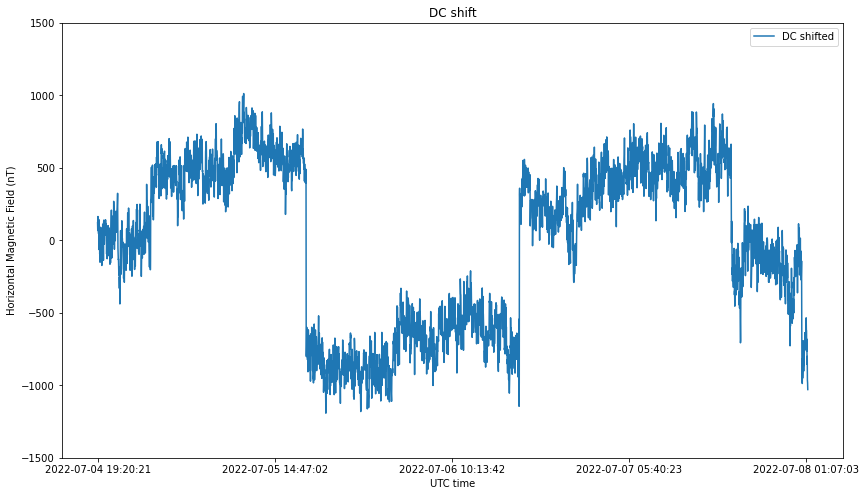

In [9]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
plt.title('DC shift')
plt.plot(date, mag, label='DC shifted')
plt.xlabel('UTC time')
plt.ylabel('Horizontal Magnetic Field (nT)')
plt.ylim(-1500,1500)
xticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(xticks)
plt.legend()
plt.show()

## Digital filter forward and backward to a signal (signal.filtfilt and signal.butter)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
 
    scipy.signal.butter(N, Wn, btype='low', analog=False, output='ba', fs=None)

    Butterworth digital and analog filter design.

    Design an Nth-order digital or analog Butterworth filter and return the filter coefficients.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html
    
    scipy.signal.filtfilt(b, a, x, axis=- 1, padtype='odd', padlen=None, method='pad', irlen=None)

    Apply a digital filter forward and backward to a signal.

    This function applies a linear digital filter twice, once forward and once backwards. The combined filter has zero phase and a filter order twice that of the original.

    The function provides options for handling the edges of the signal.

    The function sosfiltfilt (and filter design using output='sos') should be preferred over filtfilt for most filtering tasks, as second-order sections have fewer numerical problems"

More info: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

In [10]:
# Parameters
cutoff = 0.1                     # Cutoff frequency (cycle/70seconds)
fs = 30                          # Sampling frequency (cycle/70seconds)
order = 5                        # Filter order
btype = 'highpass'               # Type of filter
padlen = 10                      # Number of elements by which to extend x at both ends of axis before applying the filter
nyq = 0.5 * fs                   # Nyquist frequency = 1/2 of sampling frequency (cycle/70seconds)
normal_cutoff = cutoff/nyq       # Critical frequency

# Butterworth filter
b, a = signal.butter(order, normal_cutoff, btype, analog=False)

# Digital filter forward and backward to a signal
filtfilt_mag = signal.filtfilt(b, a, mag, padtype='even', padlen=padlen, method='gust')

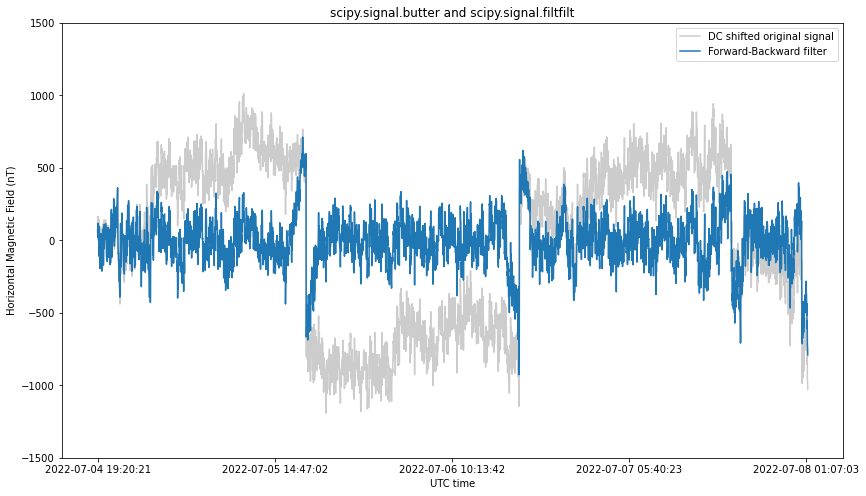

In [11]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
plt.title('scipy.signal.butter and scipy.signal.filtfilt')
plt.plot(date, mag, label='DC shifted original signal', color='grey', alpha=0.4)
plt.plot(date, filtfilt_mag, label='Forward-Backward filter')
plt.xlabel('UTC time')
plt.ylabel('Horizontal Magnetic Field (nT)')
plt.ylim(-1500,1500)
xticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(xticks)
plt.legend()
plt.show()

## Savitzky-Golay filter

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html#scipy.signal.savgol_filter
    
    scipy.signal.savgol_filter(x, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)

    Apply a Savitzky-Golay filter to an array.

    This is a 1-D filter. If x has dimension greater than 1, axis determines the axis along which the filter is applied.

In [12]:
# Parameters
window_length = 99                 # Length of the filter window
polyorder = 5                      # Order of the polynomial used to fit the samples, polyorder must be less than window_length

# Savitzky-Golay filter
savgol_mag = signal.savgol_filter(mag, window_length, polyorder)

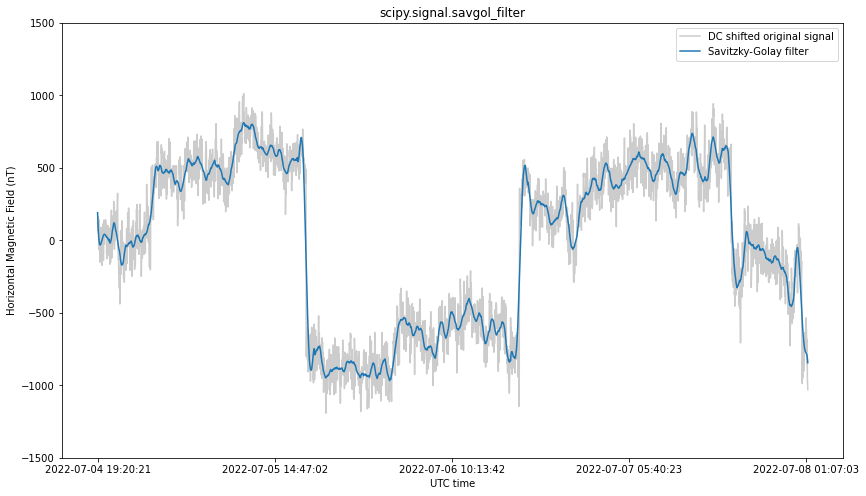

In [13]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
plt.title('scipy.signal.savgol_filter')
plt.plot(date, mag, label='DC shifted original signal', color='grey', alpha=0.4)
plt.plot(date, savgol_mag, label='Savitzky-Golay filter')
plt.xlabel('UTC time')
plt.ylabel('Horizontal Magnetic Field (nT)')
plt.ylim(-1500,1500)
xticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(xticks)
plt.legend()
plt.show()

## FFT 1: low pass filter

Plot the power of the FFT of a signal and inverse FFT back to reconstruct
a signal.

This example demonstrate :func:`scipy.fftpack.fft`,
:func:`scipy.fftpack.fftfreq` and :func:`scipy.fftpack.ifft`. It
implements a basic filter that is very suboptimal, and should not be
used.

Source: https://scipy-lectures.org/intro/scipy/auto_examples/plot_fftpack.html<br>
For all FFT filtering: https://numpy.org/doc/stable/reference/routines.fft.html

In [14]:
from scipy import fftpack

In [15]:
sig_fft = fftpack.fft(mag)                                 # Discrete Fourier transform of the signal
power = np.abs(sig_fft)**2                                 # Power (sig_fft is of complex dtype)
sample_freq = fftpack.fftfreq(mag.size, d = timestep)      # Corresponding frequencies, Discrete Fourier Transform sample frequencies

# Find the peak frequency: only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]
print(peak_freq)

# We now remove all the high frequencies and transform back from frequencies to signal.
high_freq_fft = sig_fft.copy()
high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
ffthighfreq = fftpack.ifft(high_freq_fft)

7.1232681554297115e-06


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


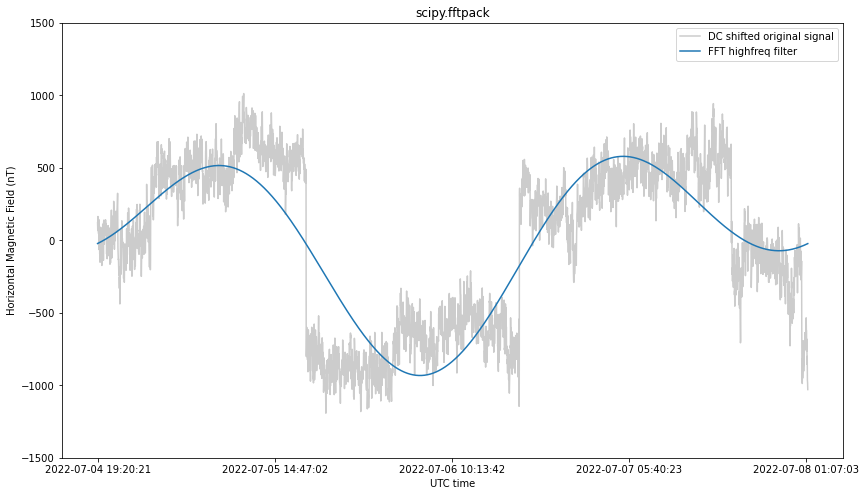

In [16]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
plt.title('scipy.fftpack')
plt.plot(date, mag, label='DC shifted original signal', color='grey', alpha=0.4)
plt.plot(date, ffthighfreq, label='FFT highfreq filter')
plt.xlabel('UTC time')
plt.ylabel('Horizontal Magnetic Field (nT)')
plt.ylim(-1500,1500)
xticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(xticks)
plt.legend()
plt.show()

In [17]:
# Subtract high frequencies
ffthighfreq_mag = mag - ffthighfreq

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


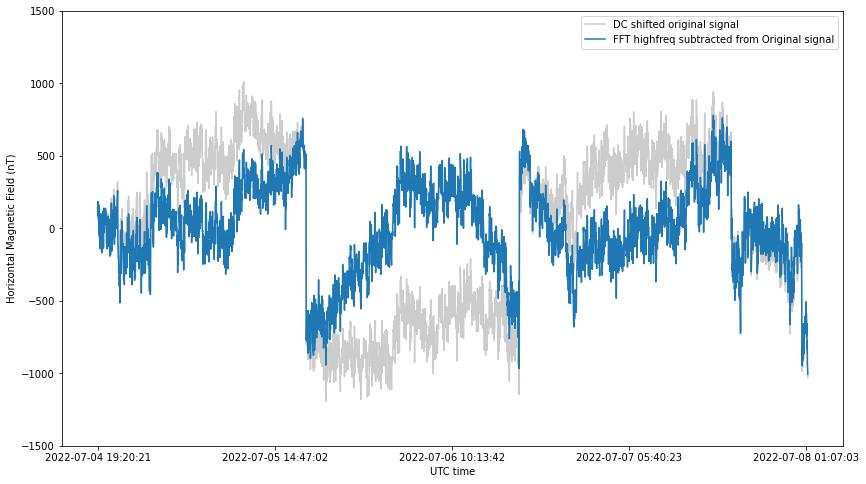

In [18]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
plt.plot(date, mag, label='DC shifted original signal', color='grey', alpha=0.4)
plt.plot(date, ffthighfreq_mag, label='FFT highfreq subtracted from Original signal')
plt.xlabel('UTC time')
plt.ylabel('Horizontal Magnetic Field (nT)')
plt.ylim(-1500,1500)
xticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(xticks)
plt.legend()
plt.show()

## FFT 2: bandpass filter

Source: https://stackoverflow.com/questions/19122157/fft-bandpass-filter-in-python

In [19]:
from scipy.fftpack import rfft, irfft, fftfreq

In [20]:
W = fftfreq(mag.size, d = timestep)    # Discrete Fourier Transform sample frequencies
f_signal = rfft(mag)                   # computes the one-dimensional n-point discrete Fourier Transform (DFT) 
                                       # of a real-valued array by means of an efficient algorithm called the 
                                       # Fast Fourier Transform (FFT)

low = peak_freq                        # Low frequencies (cycle/70seconds)
high = 0.0004                          # High frequencies (cycle/70seconds)

print("Low freq = {:.3e} (cycle/70seconds)".format(low))
print("High freq = {:.3e} (cycle/70seconds)".format(high))

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal = f_signal.copy()
cut_f_signal[(W>high)] = 0             # High frequencies
cut_f_signal[(W<low)] = 0              # Low frequencies

fftbandpass_mag = irfft(cut_f_signal)  # Computes the inverse of rfft

Low freq = 7.123e-06 (cycle/70seconds)
High freq = 4.000e-04 (cycle/70seconds)


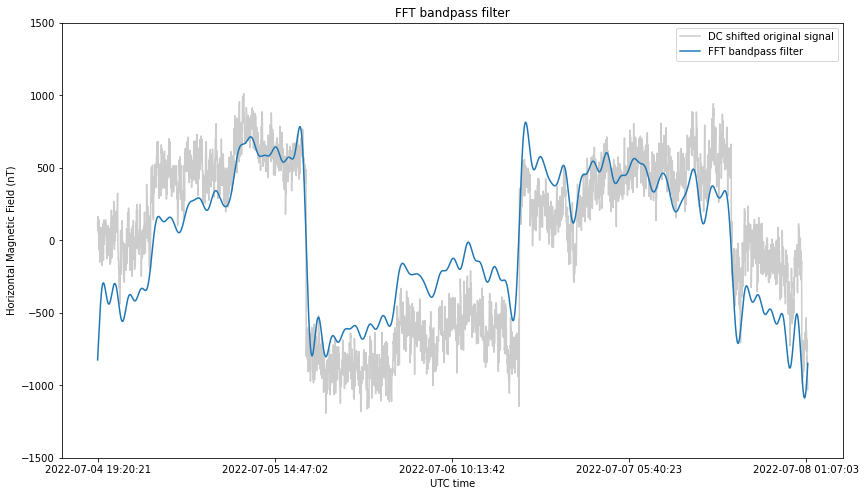

In [21]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
plt.plot(date, mag, label='DC shifted original signal', color='grey', alpha=0.4)
plt.plot(date, fftbandpass_mag, label='FFT bandpass filter')
plt.title('FFT bandpass filter')
plt.xlabel('UTC time')
plt.ylabel('Horizontal Magnetic Field (nT)')
plt.ylim(-1500,1500)
xticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(xticks)
plt.legend()
plt.show()

## Combining Digital filter forward and backward to a signal (signal.butter and signal.filtfilt) and FFT bandpass filter (rfft and irfft)

In [22]:
### Finding the low freq cutoff ###

sig_fft = fftpack.fft(mag)                                 # Discrete Fourier transform of the signal
power = np.abs(sig_fft)**2                                 # Power (sig_fft is of complex dtype)
sample_freq = fftpack.fftfreq(mag.size, d = timestep)      # Corresponding frequencies, Discrete Fourier Transform sample frequencies

# Find the peak frequency: only the positive frequencies
pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
peak_freq = freqs[power[pos_mask].argmax()]

low = peak_freq                        # Low frequencies (cycle/70seconds)
high = 0.0004                          # High frequencies (cycle/70seconds)

### FFT bandpass filter ###
W = fftfreq(mag.size, d = timestep)    # Discrete Fourier Transform sample frequencies
f_signal = rfft(mag)                   # computes the one-dimensional n-point discrete Fourier Transform (DFT) 
                                       # of a real-valued array by means of an efficient algorithm called the 
                                       # Fast Fourier Transform (FFT)

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal = f_signal.copy()
cut_f_signal[(W>high)] = 0             # High frequencies
cut_f_signal[(W<low)] = 0              # Low frequencies

fftbandpass_mag = irfft(cut_f_signal)  # Computes the inverse of rfft

### Filtfilt filter ###
cutoff = 0.1                     # Cutoff frequency (cycle/70seconds)
fs = 30                          # Sampling frequency (cycle/70seconds)
order = 5                        # Filter order
btype = 'highpass'               # Type of filter
padlen = 10                      # Number of elements by which to extend x at both ends of axis before applying the filter
nyq = 0.5 * fs                   # Nyquist frequency = 1/2 of sampling frequency (cycle/70seconds)
normal_cutoff = cutoff/nyq       # Critical frequency

# Butterworth filter
b, a = signal.butter(order, normal_cutoff, btype, analog=False)

# Digital filter forward and backward to a signal
bandpassfiltfilt_mag = signal.filtfilt(b, a, fftbandpass_mag, padtype='even', padlen=padlen, method='gust')

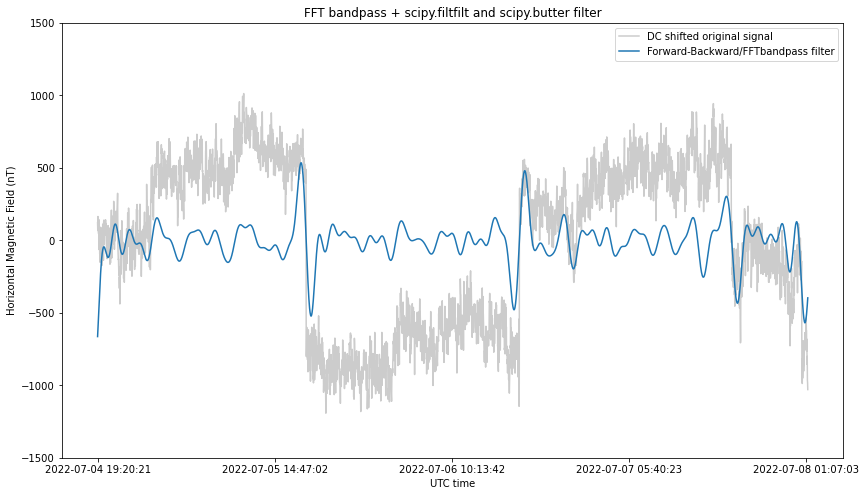

In [23]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
plt.plot(date, mag, label='DC shifted original signal', color='grey', alpha=0.4)
plt.title('FFT bandpass + scipy.filtfilt and scipy.butter filter')
plt.plot(date, bandpassfiltfilt_mag, label='Forward-Backward/FFTbandpass filter')
plt.ylim(-1500,1500)
plt.xlabel('UTC time')
plt.ylabel('Horizontal Magnetic Field (nT)')
xticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(xticks)
plt.legend()
plt.show()

## Power spectrum

Source: https://stackoverflow.com/questions/15382076/plotting-power-spectrum-in-python

In [24]:
# Calculate power spectrum
ps = np.abs(np.fft.fft(mag))**2

# Calculate frequencies
time_step = 70
sample_freq = np.fft.fftfreq(mag.size, time_step)
idx = np.argsort(sample_freq)

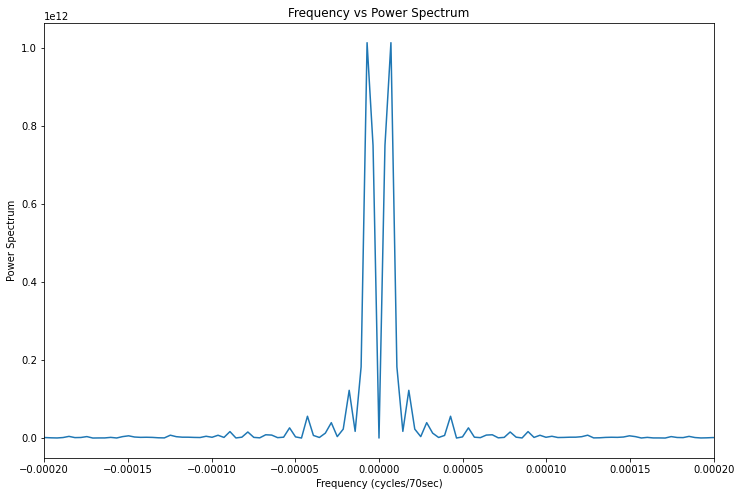

In [25]:
# Plot power spectrum in terms of frequency
plt.figure(figsize=(12, 8))
plt.title('Frequency vs Power Spectrum')
plt.plot(sample_freq[idx], ps[idx])
plt.xlabel("Frequency (cycles/70sec)")
plt.ylabel("Power Spectrum")
plt.xlim(-0.0002,0.0002)
plt.show()

In [26]:
# Frequency to period conversion
sample_period = 1/sample_freq * 1/60

C:\Users\judit\AppData\Local\Temp/ipykernel_10756/3486845057.py:2: RuntimeWarning: divide by zero encountered in true_divide
  sample_period = 1/sample_freq * 1/60


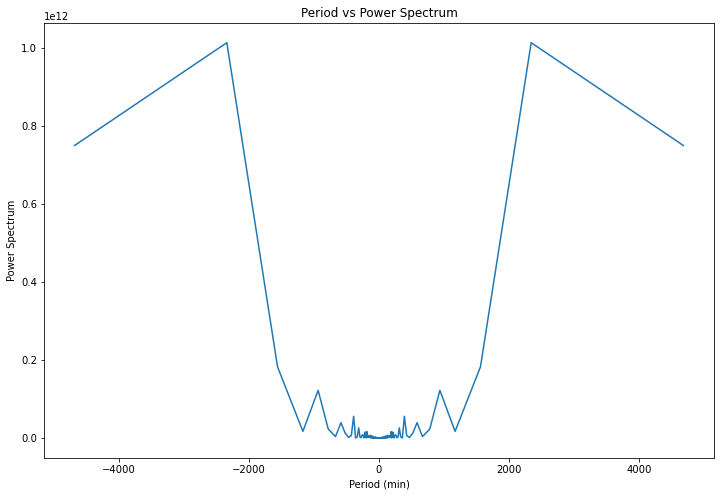

In [27]:
# Plot power spectrum in terms of period
plt.figure(figsize=(12, 8))
plt.title('Period vs Power Spectrum')
plt.plot(sample_period[idx], ps[idx])
plt.xlabel("Period (min)")
plt.ylabel("Power Spectrum")
#plt.xlim(-0.0002,0.0002)
plt.show()

In [28]:
# Concentrate on the positive values
pos_mask = np.where(freqs > 0)
freqs = sample_freq[pos_mask]
ps_pos = ps[pos_mask]

# Find lowest frequency cutoff
peak_freq = freqs[ps_pos.argmax()]
print("Low freq cutoff = {}".format(peak_freq))

# Find highest frequency cutoff 
new_ps = np.sort(ps_pos)                  # Sort array
inx2 = np.where(ps_pos==new_ps[-2])       # Find second to last value (second highest value)
peak_freq2 = sample_freq[inx2]
print("High freq cutoff = {}".format(peak_freq2[0]))

Low freq cutoff = 7.1232681554297115e-06
High freq cutoff = 3.5616340777148558e-06


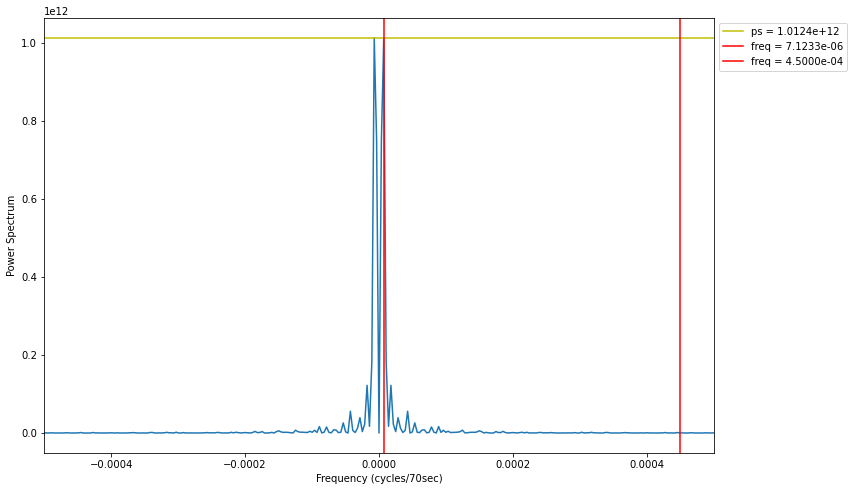

In [29]:
# Plot
plt.figure(figsize=(12, 8))
plt.plot(sample_freq[idx], ps[idx])
plt.axhline(y=new_ps[-1], color='y', label="ps = {:.4e}".format(new_ps[-1]))
plt.axvline(x=peak_freq, color='r', label="freq = {:.4e}".format(peak_freq))
plt.axvline(x=0.00045, color='r', label="freq = {:.4e}".format(0.00045))
plt.xlabel("Frequency (cycles/70sec)")
plt.ylabel("Power Spectrum")
plt.xlim(-0.0005,0.0005)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [30]:
print(new_ps[-3])
inx3 = np.where(ps_pos==new_ps[-3])       # Find second to last value (second highest value)
peak_freq3 = sample_freq[inx3]
print(peak_freq3)

182334498020.17584
[1.06849022e-05]


## Widget

In [31]:
# Widget to test filtering
from ipywidgets import interactive, FloatSlider, Layout, Button, Output, VBox
from IPython.display import display, clear_output
from IPython.display import Javascript

In [32]:
# Frequency cutoffs
best_low = peak_freq             # Low frequency cutoff (cycle/70seconds)
best_high = 0.0004               # High frequency cutoff (cycle/70seconds)

# Filter parameters
cutoff = 0.1                     # Cutoff frequency (cycle/70seconds)
fs = 30                          # Sampling frequency (cycle/70seconds)
order = 5                        # Filter order
btype = 'highpass'               # Type of filter
padlen = 10                      # Number of elements by which to extend x at both ends of axis before applying the filter
nyq = 0.5 * fs                   # Nyquist frequency = 1/2 of sampling frequency (cycle/70seconds)
normal_cutoff = cutoff/nyq       # Critical frequency

In [33]:
# Plotting function
def Plotting_f(low,high):
    
    ### FFT bandpass filter ###
    W = fftfreq(mag.size, d = timestep)
    f_signal = rfft(mag)
    # If our original signal time was in seconds, this is now in Hz    
    cut_f_signal = f_signal.copy()
    cut_f_signal[(W>high)] = 0           # High frequencies (cycle/70sec)
    cut_f_signal[(W<low)] = 0            # Low frequencies (cycle/70sec)
    fftbandpass_mag = irfft(cut_f_signal)
    
    ### Filtfilt filter ###
    b, a = signal.butter(order, normal_cutoff, btype, analog=False)
    bandpassfiltfilt_mag = signal.filtfilt(b, a, fftbandpass_mag, padlen=padlen)
    
    # Set up two plots next to each other
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
    plt.subplots_adjust(wspace=0.1, hspace=0)
    f.set_figheight(6)
    f.set_figwidth(14)

    # Plot 1: Filtered data
    ax1.plot(date, mag, label='DC shifted original signal', color='grey', alpha=0.4)
    ax1.plot(date, bandpassfiltfilt_mag, label='Filtered data - combo')
    #ax1.plot(date, fftbandpass_mag, label='Filtered data - bandpass')
    ax1.set_xlabel("UTC time")
    ax1.set_ylabel("Horizontal Magnetic Field (nT)")
    xticks = ticker.MaxNLocator(3)
    ax1.xaxis.set_major_locator(xticks)
    ax1.legend()
    
    # Plot 2: Power spectrum
    ax2.plot(sample_freq[idx], ps[idx])
    ax2.axhline(y=new_ps[-1], color='y', label="ps = {:.4e}".format(new_ps[-1]))
    ax2.axvline(x=low, color='r', label="freq = {:.4e}".format(low))
    ax2.axvline(x=high, color='g', label="freq = {:.4e}".format(high))
    ax2.set_xlim(-1e-6,6.2e-4)
    ax2.set_xlabel("Frequency (cycle/70seconds)")
    ax2.set_ylabel("Power Spectrum")
    ax2.legend(bbox_to_anchor=(1,1), loc="upper left")

# Define Sliders 
style = {'description_width': 'initial'}
layout = {'width':'800px'}

lowfreq = FloatSlider(min=0, max=1.5e-4, step=1e-5, 
                value=best_low, #6.83e-6                  0           0.00000683     0.00004   1e-6
                description='Lowest frequency cutoff', 
                readout=True,
                readout_format='.3e', 
                orientation='horizontal', 
                style=style, layout=layout)

highfreq = FloatSlider(min=4.5e-5, max=6e-4, step=1e-5, 
                value=best_high, #4e-4                    0.000045       0.0004       0.0006
                description='Highest frequency cutoff', 
                readout=True,
                readout_format='.3e', 
                orientation='horizontal', 
                style=style, layout=layout)

def interactive_plot(Plotting_f):
    interact = interactive(Plotting_f, low=lowfreq, high=highfreq, continuous_update=False)
    return interact

# Button to revert back to best values
button = Button(
    description="Best",
    button_style='success',
    icon='check')
out = Output()

def on_button_clicked(_):
    lowfreq.value = best_low
    highfreq.value = best_high
button.on_click(on_button_clicked)

# Display
VBox([button,out,interactive_plot(Plotting_f)])

## Amplitude cutoff

In [34]:
amplitude = []
for m in mag:
    amp = (max(m)-min(m))/2
    

TypeError: 'numpy.float64' object is not iterable

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
plt.plot(date, mag, label='DC shifted original signal', color='grey', alpha=0.4)
plt.title('Amplitude')
plt.plot(date, amplitude, label='Amplitude')
plt.ylim(-1500,1500)
plt.xlabel('UTC time')
plt.ylabel('Horizontal Magnetic Field (nT)')
xticks = ticker.MaxNLocator(5)
ax.xaxis.set_major_locator(xticks)
plt.legend()
plt.show()

## Wavelet

https://pywavelets.readthedocs.io/en/latest/<br>
https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html

Discrete Wavelet Transform (DWT)

Wavelet transform has recently become a very popular when it comes to analysis, de-noising and compression of signals and images. This section describes functions used to perform single- and multilevel Discrete Wavelet Transforms.
Single level dwt

pywt.dwt(data, wavelet, mode='symmetric', axis=-1)

    Single level Discrete Wavelet Transform.
    Parameters:	
    data : array_like
        Input signal
    wavelet : Wavelet object or name
        Wavelet to use
    mode : str, optional
        Signal extension mode, see Modes.
    axis: int, optional
        Axis over which to compute the DWT. If not given, the last axis is used.
    Returns:	
    (cA, cD) : tuple
        Approximation and detail coefficients.

In [ ]:
import pywt
import pywt.data

# Wavelet transform
coeffs2 = pywt.dwt(mag, 'db1', mode='smooth')
print(coeffs2)